# **PROKPROMPRED**
## This notebook is the documentation and code for experimenting with the nucleotide transformers for prokaryotic promoter prediction pipeline (prokprompred).

Notebook adapted from https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling_with_peft.ipynb

Nucleotide Transformer Citation: Dalla-Torre et al, 2023: "Nucleotide Transformer: A Foundation Model for Genomics", available at https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2.

**Note: Re-running this so results may vary**

In [1]:
# Install
!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install transformers[torch]
!pip install accelerate -U
!pip install peft
!pip install dm-haiku
!pip install jax
!pip install nucleotide

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Ensure local environment has latest library installs. To share the model and generate results, log in to the Huggingface hub.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# **Transfer Learning**

### **Fine-Tuning the Nucleotide-transformer with LoRA**


Model Details
```
| Model name          | Num layers | Num parameters | Training dataset       |
|---------------------|------------|----------------|------------------------|
| `500M Human Ref`    | 24         | 500M           | Human reference genome |
| `500M 1000G`        | 24         | 500M           | 1000G genomes          |
| `2.5B 1000G`        | 32         | 2.5B           | 1000G genomes          |
| `2.5B Multispecies` | 32         | 2.5B           | Multi-species dataset  |

```



## **Importing required packages and setting up PEFT model**

### **Import and install**

In [19]:
# Imports
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define the working device
device = torch.device("cuda")

### **Prepare and create the model for fine-tuning**

The `AutoModelForSequenceClassification` module automatically loads the model and adds a simple classification head on top of the final embeddings.

In [5]:
num_labels_promoter = 2

# Load the model
# model_name = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
# model_name = "InstaDeepAI/nucleotide-transformer-2.5b-1000g"
model_name = "InstaDeepAI/nucleotide-transformer-500m-1000g"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels_promoter)

# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels_promoter, trust_remote_code=True)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-1000g and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The LoRA parameters are now added to the model, and the parameters that will be finetuned are indicated.

In [6]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=1, lora_alpha=32, lora_dropout=0.1, target_modules= ["query", "value"],
    # modules_to_save=["intermediate"] # modules that are not frozen and updated during the training
)

In [7]:
from peft import get_peft_model

lora_classifier = get_peft_model(model, peft_config) # transform our classifier into a peft model
lora_classifier.print_trainable_parameters()
lora_classifier.to(device) # Put the model on the GPU

trainable params: 1,765,122 || all params: 482,205,925 || trainable%: 0.3661


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(4105, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1002, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-23): 24 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=1, bias=False)
                    )
                    (lora_B): ModuleDict(
   

## **Promoter prediction**

### **Dataset loading and preparation**

In [8]:
from datasets import load_dataset, Dataset
import pandas as pd

# Loading promoter dataset created for microbial promoter classification task

train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

train_dataset_promoter = Dataset.from_pandas(train_df, split="train")
test_dataset_promoter = Dataset.from_pandas(test_df, split="test")



In [9]:

# Get training data
train_sequences_promoter = train_dataset_promoter['sequence']
train_labels_promoter = train_dataset_promoter['label']

# Split the dataset into a training and a validation dataset
train_sequences_promoter, validation_sequences_promoter, train_labels_promoter, validation_labels_promoter = train_test_split(train_sequences_promoter,
                                                                              train_labels_promoter, test_size=0.05, random_state=42)

# Get test data
test_sequences_promoter = test_dataset_promoter['sequence']
test_labels_promoter = test_dataset_promoter['label']

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

In [10]:
idx_sequence = -1
sequence, label = train_sequences_promoter[idx_sequence], train_labels_promoter[idx_sequence]
print(f"The DNA sequence is {sequence}.")
print(f"Its associated label is label {label}.")


The DNA sequence is CGTTCAAAAATGACGATCAGAAATCAGCTTATGCACTGGGTGCTTCGCTGGGTCGTTACATGGAAAACTCTCTTAAAGAAC.
Its associated label is label 1.


### **Tokenizing the datasets**

All inputs to neural nets must be numerical. The process of converting strings into numerical indices suitable for a neural net is called **tokenization**.

In [11]:

# Load the tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [12]:

# Promoter dataset
ds_train_promoter = Dataset.from_dict({"data": train_sequences_promoter,'labels':train_labels_promoter})
ds_validation_promoter = Dataset.from_dict({"data": validation_sequences_promoter,'labels':validation_labels_promoter})
ds_test_promoter = Dataset.from_dict({"data": test_sequences_promoter,'labels':test_labels_promoter})

In [13]:

def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

In [14]:

# Creating tokenized promoter dataset
tokenized_datasets_train_promoter = ds_train_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation_promoter = ds_validation_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test_promoter = ds_test_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/245124 [00:00<?, ? examples/s]

Map:   0%|          | 0/12902 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

### **Fine-tuning and evaluation**

Fine-tune by experimenting with hyperparameters

In [15]:

batch_size = 16
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-lora-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    # num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_ACCURACY",
    label_names=["labels"],
    dataloader_drop_last=True,
    # max_steps= 10000
    max_steps=1000
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Define the metrics

In [30]:
from sklearn import metrics


# Define the metric for the evaluation based on Silva-Rocha et al., 2020
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    return get_metrics(predictions, references)

def get_metrics(preds, labels):
    epsilon = 1e-10
    TN, FP, FN, TP = metrics.confusion_matrix(preds, labels).ravel()

    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    mcc = matthews_corrcoef(preds, labels)

    fpr = FP / (FP + TN + epsilon) # False Positive Rate
    tpr = TP / (TP + FN + epsilon) # True Positive Rate
    return {"ACCURACY": accuracy, "SENSITIVITY": sensitivity, "SPECIFICITY": specificity, "MCC": mcc, "TRUE POSITIVE RATE": tpr, "FALSE POSITIVE RATE": fpr}



In [17]:

trainer = Trainer(
    model.to(device),
    args_promoter,
    train_dataset= tokenized_datasets_train_promoter,
    eval_dataset= tokenized_datasets_validation_promoter,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-17-8e081253791b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Finetune model using `train` method

In [20]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Sensitivity,Specificity,Mcc,True positive rate,False positive rate
100,0.515800,0.533634,0.729866,0.674770,0.824963,0.481755,0.674770,0.175037
200,0.497700,0.445852,0.792366,0.767159,0.820925,0.587026,0.767159,0.179075
300,0.483100,0.448219,0.785759,0.741207,0.845943,0.580658,0.741207,0.154057
400,0.476000,0.415154,0.809779,0.831707,0.791542,0.620703,0.831707,0.208458
500,0.438700,0.426256,0.804260,0.783542,0.826836,0.609905,0.783542,0.173164
600,0.453100,0.397677,0.818797,0.846020,0.796675,0.639344,0.846020,0.203325
700,0.441600,0.395263,0.822528,0.838785,0.808489,0.645631,0.838785,0.191511
800,0.394900,0.393487,0.819419,0.852087,0.793598,0.641338,0.852087,0.206402
900,0.376600,0.393546,0.824005,0.862710,0.794223,0.651429,0.862710,0.205777
1000,0.400700,0.387328,0.823305,0.859018,0.795433,0.649552,0.859018,0.204567


Step,Training Loss,Validation Loss


Could not locate the best model at InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-lora-NucleotideTransformer/checkpoint-900/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Save the model, history, and results

In [21]:
trainer.save_model(f"{model_name}-1000steps-finetuned-lora-NucleotideTransformer")

In [22]:

pd.DataFrame(trainer.state.log_history).to_csv(f"{model_name}_validation_history.csv")


In [23]:

test_results = trainer.evaluate(tokenized_datasets_test_promoter)
data = {}
data[model_name] = test_results
pd.DataFrame(data).to_csv(f"{model_name}_test_results.csv")

In [24]:
# !zip -r InstaDeepAI.zip InstaDeepAI_zipped
from google.colab import files
files.download("InstaDeepAI")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Validation accuracy**

In [25]:

data = pd.read_csv("./InstaDeepAI/nucleotide-transformer-500m-1000g_validation_history.csv")[["eval_ACCURACY", "step"]].dropna()

# Create some data to plot
x = list(data["step"])

y = list(data["eval_ACCURACY"])

labels = ["NT 500m-1000g"]


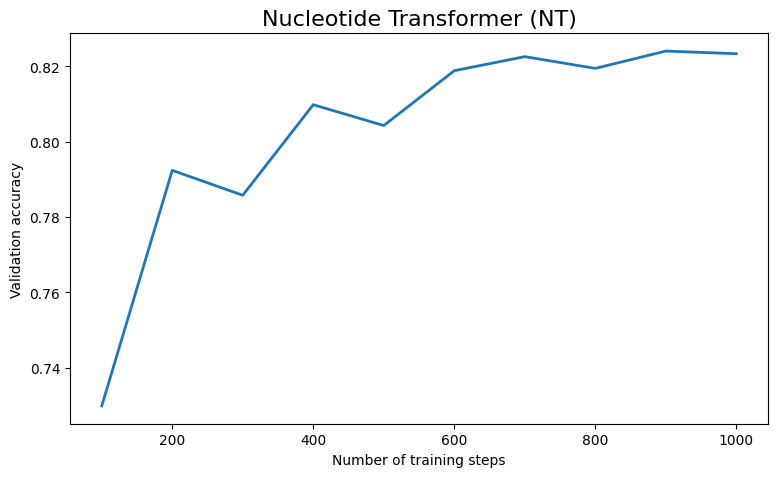

In [26]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels


# Define a nice color palette:
colors = ["#02e39c"]

# Plot
ax.plot(x, y, linewidth=2)

ax.set_xlabel("Number of training steps")
ax.set_ylabel("Validation accuracy")
ax.set_title("Nucleotide Transformer (NT)")

plt.tight_layout()


#### **Test accuracy**

In [27]:
data = pd.read_csv("./InstaDeepAI/nucleotide-transformer-500m-1000g_test_results.csv").set_index("Unnamed: 0").to_dict()


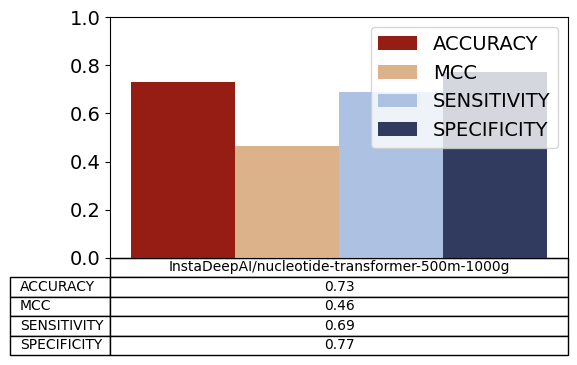

In [28]:
import matplotlib.pyplot as plt

colors = ['#961D13', '#DBB289', '#ADC1E2', '#303B5F']

models = list(data.keys())
metrics = ['ACCURACY', 'MCC', 'SENSITIVITY', 'SPECIFICITY']

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

x = range(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    values = [data[model][f'eval_{metric}'] for model in models]
    ax.bar([j + i*width for j in x], values, width, label=metric, color=colors[i])

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylim(0, 1)
ax.legend(ncol=1)

# Create a table
table_data = [[f'{data[model][f"eval_{metric}"]:.2f}' for model in models] for metric in metrics]
table = ax.table(cellText=table_data, rowLabels=metrics, colLabels=models, loc='bottom', cellLoc='center')
table.scale(1, 1.5)
table.set_fontsize(10)

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()


#### **Here, further fine-tune with *E. coli* training data.**



In [31]:
from peft import LoraConfig, TaskType

model_path = "/content/InstaDeepAI/nucleotide-transformer-500m-1000g-1000steps-finetuned-lora-NucleotideTransformer"
model_fine_tuned = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels_promoter)


peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=1, lora_alpha= 32, lora_dropout=0.1, target_modules= ["query", "value"],
    #modules_to_save=["intermediate"] # modules that are not frozen and updated during the training
)

# ==============================================================================
from peft import get_peft_model

lora_classifier = get_peft_model(model_fine_tuned, peft_config) # transform our classifier into a peft model
lora_classifier.print_trainable_parameters()
lora_classifier.to(device) # Put the model on the GPU

# ==============================================================================
from datasets import load_dataset, Dataset
import pandas as pd

# Loading promoter dataset created for microbial promoter classification task

train_df = pd.read_csv("./train_coli.csv")
test_df = pd.read_csv("./test.csv")

train_dataset_promoter = Dataset.from_pandas(train_df, split="train")
test_dataset_promoter = Dataset.from_pandas(test_df, split="test")

# Get training data
train_sequences_promoter = train_dataset_promoter['sequence']
train_labels_promoter = train_dataset_promoter['label']

# Split the dataset into a training and a validation dataset
train_sequences_promoter, validation_sequences_promoter, train_labels_promoter, validation_labels_promoter = train_test_split(train_sequences_promoter,
                                                                              train_labels_promoter, test_size=0.05, random_state=42)
# Get test data
test_sequences_promoter = test_dataset_promoter['sequence']
test_labels_promoter = test_dataset_promoter['label']

# ==============================================================================
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
# Tokenize the data
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

# ==============================================================================
# Promoter dataset
ds_train_promoter = Dataset.from_dict({"data": train_sequences_promoter,'labels':train_labels_promoter})
ds_validation_promoter = Dataset.from_dict({"data": validation_sequences_promoter,'labels':validation_labels_promoter})
ds_test_promoter = Dataset.from_dict({"data": test_sequences_promoter,'labels':test_labels_promoter})


# ==============================================================================
# Creating tokenized promoter dataset
tokenized_datasets_train_promoter = ds_train_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation_promoter = ds_validation_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test_promoter = ds_test_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)


# ==============================================================================
batch_size = 16
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-finetuned-10000steps-lora-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    # num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_ACCURACY",
    label_names=["labels"],
    dataloader_drop_last=True,
    # max_steps= 10000
    max_steps= 1000
)
trainer_coli = Trainer(
    model_fine_tuned.to(device),
    args_promoter,
    train_dataset= tokenized_datasets_train_promoter,
    eval_dataset= tokenized_datasets_validation_promoter,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ==============================================================================

train_coli_results = trainer_coli.train()

Some weights of the model checkpoint at /content/InstaDeepAI/nucleotide-transformer-500m-1000g-1000steps-finetuned-lora-NucleotideTransformer were not used when initializing EsmForSequenceClassification: ['classifier.modules_to_save.default.dense.bias', 'classifier.modules_to_save.default.dense.weight', 'classifier.modules_to_save.default.out_proj.bias', 'classifier.modules_to_save.default.out_proj.weight', 'classifier.original_module.dense.bias', 'classifier.original_module.dense.weight', 'classifier.original_module.out_proj.bias', 'classifier.original_module.out_proj.weight', 'esm.encoder.layer.0.attention.self.query.base_layer.bias', 'esm.encoder.layer.0.attention.self.query.base_layer.weight', 'esm.encoder.layer.0.attention.self.query.lora_A.default.weight', 'esm.encoder.layer.0.attention.self.query.lora_B.default.weight', 'esm.encoder.layer.0.attention.self.value.base_layer.bias', 'esm.encoder.layer.0.attention.self.value.base_layer.weight', 'esm.encoder.layer.0.attention.self.val

trainable params: 1,765,122 || all params: 482,205,925 || trainable%: 0.3661


Map:   0%|          | 0/16370 [00:00<?, ? examples/s]

Map:   0%|          | 0/862 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-31-e344b317c7fe>:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_coli = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Sensitivity,Specificity,Mcc,True positive rate,False positive rate
100,0.808200,0.665489,0.530048,0.511598,0.785714,0.149007,0.511598,0.214286
200,0.653800,0.539637,0.729567,0.796774,0.689655,0.470440,0.796774,0.310345
300,0.566700,0.514882,0.746394,0.798193,0.712000,0.499754,0.798193,0.288000
400,0.519300,0.616110,0.662260,0.598160,0.894444,0.405720,0.598160,0.105556
500,0.460200,0.510903,0.769231,0.833846,0.727811,0.548132,0.833846,0.272189
600,0.472500,0.491609,0.758413,0.839869,0.711027,0.531363,0.839869,0.288973
700,0.466700,0.468532,0.780048,0.744589,0.824324,0.565504,0.744589,0.175676
800,0.474500,0.448728,0.789663,0.778571,0.800971,0.579598,0.778571,0.199029
900,0.425000,0.443148,0.800481,0.787234,0.814181,0.601415,0.787234,0.185819
1000,0.412500,0.437076,0.802885,0.811705,0.794989,0.605851,0.811705,0.205011


In [32]:
trainer_coli.save_model(f"{model_name}-finetuned-10000steps-finetuned-10000steps-lora-NucleotideTransformer")

pd.DataFrame(trainer_coli.state.log_history).to_csv(f"{model_name}_finetuned-10000steps-finetuned-10000steps-validation_history.csv")


test_results_coli = trainer_coli.evaluate(tokenized_datasets_test_promoter)
data = {}
data[model_name] = test_results_coli


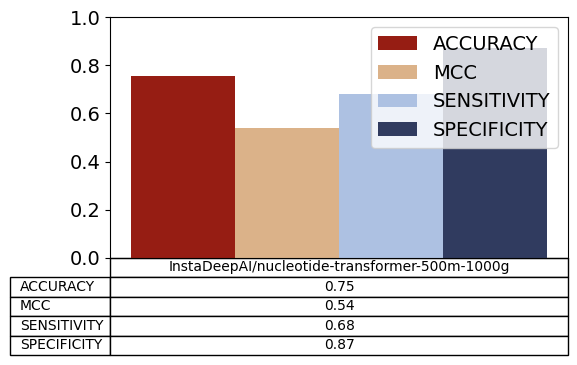

In [33]:

import matplotlib.pyplot as plt

colors = ['#961D13', '#DBB289', '#ADC1E2', '#303B5F']

models = list(data.keys())
metrics = ['ACCURACY', 'MCC', 'SENSITIVITY', 'SPECIFICITY']

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

x = range(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    values = [data[model][f'eval_{metric}'] for model in models]
    ax.bar([j + i*width for j in x], values, width, label=metric, color=colors[i])

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylim(0, 1)
ax.legend(ncol=1)

# Create a table
table_data = [[f'{data[model][f"eval_{metric}"]:.2f}' for model in models] for metric in metrics]
table = ax.table(cellText=table_data, rowLabels=metrics, colLabels=models, loc='bottom', cellLoc='center')
table.scale(1, 1.5)
table.set_fontsize(10)

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
